In [32]:
import copy
from pathlib import Path

import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

In [2]:
from shg_ml_benchmarks.utils import load_full

# Load data

In [3]:
df_full = load_full(only_unique=False)
print(df_full.shape)
print(df_full.columns)

(2699, 48)
Index(['formula_reduced', 'crystal_system', 'dRMS', 'dijk', 'elements',
       'epsij', 'src_bandgap', 'src_DB_IDs', 'src_ehull', 'src_epsij',
       'src_is_gap_direct', 'src_is_magnetic', 'src_n', 'src_theoretical', 'n',
       'nelements', 'nsites', 'pg_symbol', 'spg_number', 'spg_symbol',
       'structure', 'dKP', 'src', 'origin', 'dinv2', 'dinv3', 'abi_spg_symbol',
       'abi_spg_number', 'abi_pg_symbol', 'abi_crystal_system',
       'pg_match_abi_spga', 'dijk_rot', 'epsij_rot', 'structure_rot',
       'rot_is_conventional', 'dKP_full_wrt_dKP',
       'spga_001_spg_for_conventional', 'spga_001_pg_for_conventional',
       'rot_was_symmetrized', 'why_not_conventional_original',
       'why_not_conventional_rot', 'dKP_rot', 'dijk_full', 'dKP_full',
       'dijk_full_neum', 'dKP_full_neum', 'FOM', 'is_unique_here'],
      dtype='object')


In [4]:
df_full[df_full["nsites"] > 50]["origin"].value_counts()

hg v6        26
hg v14       14
Naccarato    11
hg v0         1
hg v8         1
hg v9         1
Name: origin, dtype: int64

In [5]:
df_full[df_full["origin"] != "Naccarato"].shape

(2141, 48)

In [6]:
df_full["origin"].value_counts().sort_index()

Naccarato    558
Pareto        26
hg v0          4
hg v1         53
hg v10        73
hg v11       100
hg v12        86
hg v13        63
hg v14        99
hg v15        97
hg v16       159
hg v17       258
hg v18       276
hg v19       181
hg v2         66
hg v3         62
hg v4         76
hg v5         45
hg v6        239
hg v7         89
hg v8         85
hg v9          4
Name: origin, dtype: int64

0


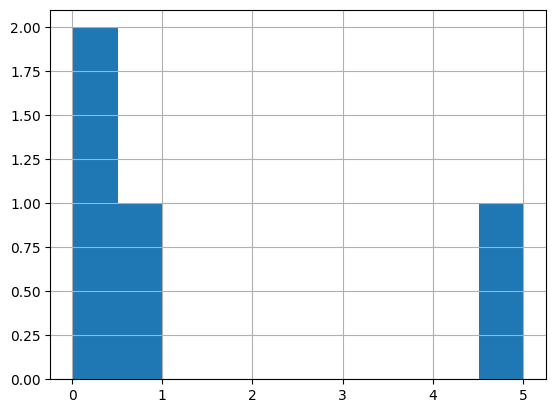

1


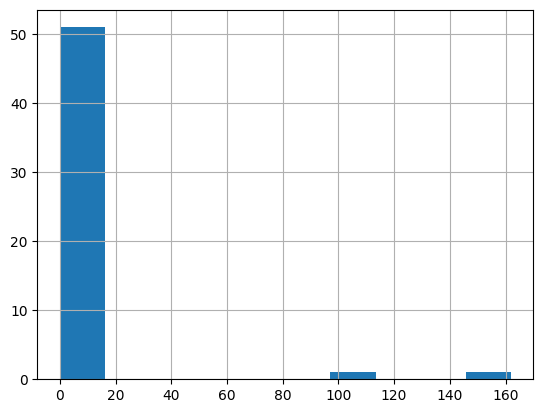

2


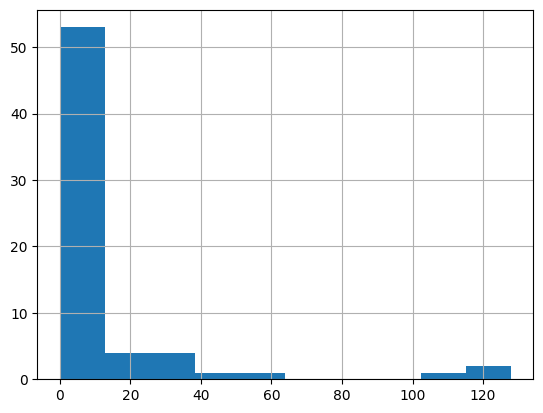

3


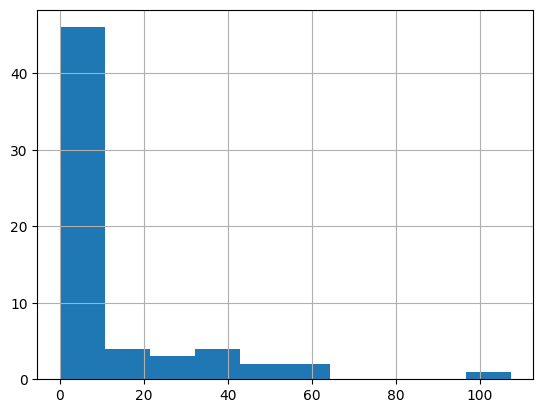

4


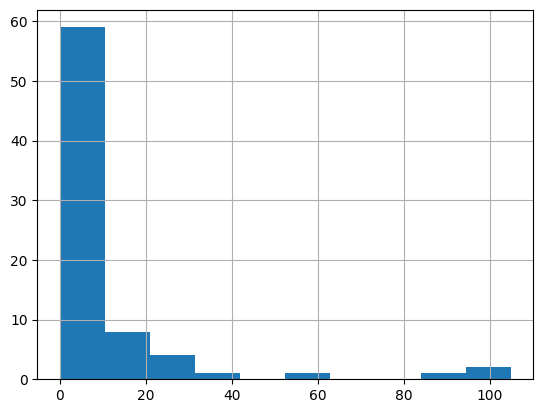

5


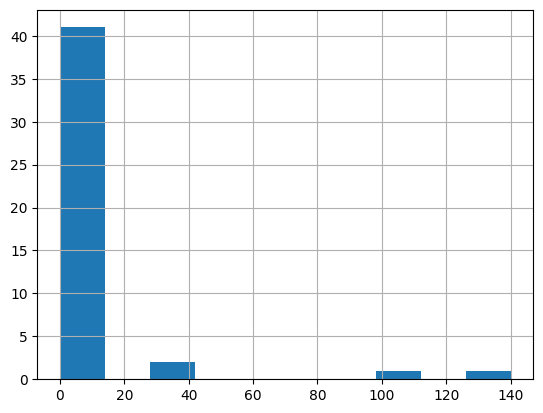

6


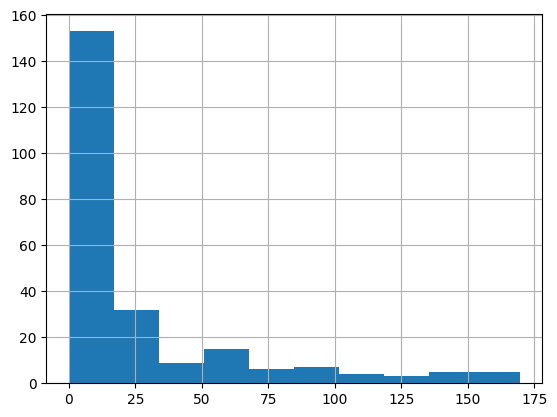

In [7]:
from matplotlib import pyplot as plt

for i in range(7):
    print(i)
    df_full[df_full["origin"] == f"hg v{i}"]["dKP"].hist()
    plt.show()

In [8]:
# Outliers to remove
idx_outliers = [
    "mp-13032",
    "mp-622018",
    "mp-1227604",
    "mp-13150",
    "mp-604884",
    "mp-28264",
]
df_full = df_full.drop(idx_outliers, axis=0)

In [21]:
a = 245.33804708552054
b = -0.7375760420942451
range_gap = np.linspace(0, round(df_full["src_bandgap"].max()), 100)
fit_pareto_t0 = a * np.exp(b * range_gap)

# Main distribution plot

In [9]:
# dKP-Eg-(ns)-KDE with log-lin inset

# ==============================================================================================================================
fig = make_subplots(
    rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.02, column_widths=[0.8, 0.2]
)

# ROW 1 COL 1 =================================================================================================================
str_origin_nac = "Naccarato"
df_tmp = df_full[df_full["origin"] == str_origin_nac]
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            color=np.real(df_tmp["n"]),
            size=5,
            showscale=True,
            colorbar=dict(
                title="<i>n<sub>s</sub></i>",
                title_font_size=36,
                orientation="v",
                #    tickvals=[1,2,3,4,5,6],
                x=0.9,
                y=0.6,
                len=0.9,
            ),
            colorscale="plasma",
        ),
        showlegend=True,
        name="Old",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

str_origin_nac = "Naccarato"
df_tmp = df_full[df_full["origin"] != str_origin_nac]
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            symbol="circle",
            size=5,
            color="lightgreen",
            showscale=False,
            line=dict(width=1, color="black"),
        ),
        showlegend=True,
        name="New",
        text=[mpid for mpid in df_tmp.index.values],
    )
)


# AXES
fig.update_xaxes(
    title="<i>E<sub>g</sub></i> (eV)",
    title_font_size=36,
    #   range = [-0.1, 8.4],
    row=1,
    col=1,
)
fig.update_yaxes(title="<i>d</i><sub>KP</sub> (pm/V)", title_font_size=36)


fig.update_layout(
    font={"family": "Arial", "size": 20},
)

# ROW 1 COL 2 =================================================================================================================
density = gaussian_kde(np.reshape(df_full["dKP"].values, (1, len(df_full))))
density.covariance_factor = lambda: 0.02  # Smoothing parameter
density._compute_covariance()

x_vals = np.linspace(
    min(df_full["dKP"].values), max(df_full["dKP"].values), 200
)  # Specifying the limits of our data
kde_dist = density(x_vals)

fig.add_trace(
    go.Scatter(
        x=kde_dist,
        y=x_vals,
        mode="lines",
        marker_color="indianred",
        fill="tozerox",
        showlegend=False,
    ),
    row=1,
    col=2,
)

fig.update_xaxes(title="Distribution", title_font_size=36, row=1, col=2)
fig.update_yaxes(title="", row=1, col=2)

# INSET =======================================================================================================================
inset = copy.deepcopy(fig.data[0])
inset.xaxis = "x3"
inset.yaxis = "y3"

inset_candidates_v1 = copy.deepcopy(fig.data[1])
inset_candidates_v1.xaxis = "x3"
inset_candidates_v1.yaxis = "y3"
inset


fig.update_layout(
    xaxis3=dict(
        domain=[0.30, 0.75],
        anchor="y3",
        #  range       = [-0.1, 8.4],
        linecolor="black",
    ),
    yaxis3=dict(
        domain=[0.60, 0.98],
        anchor="x3",
        #  range       = [-3.5, 2.6],
        type="log",
        tickvals=[0.001, 0.01, 1, 100],
        linecolor="black",
    ),
)

fig.add_trace(inset)
fig.add_trace(inset_candidates_v1)

fig.update_xaxes(
    showspikes=True,
    spikecolor="gray",
    spikethickness=2,
    spikesnap="cursor",
    spikemode="across",
)
fig.update_yaxes(
    showspikes=True,
    spikecolor="gray",
    spikethickness=2,
    spikesnap="cursor",
    spikemode="across",
)
fig.update_layout(hoverdistance=5)

# THEME OF GRAPH
fig.update_layout(template="simple_white")

fig.update_layout(width=1000, height=500)

fig.show()

# name_fig = "dKP-Eg_KDE_all_res_filtout"
# if not Path(f'figures/pdf/{name_fig}.pdf').exists():
#     fig.write_image(f'../figures/pdf/{name_fig}.pdf')
#     fig.write_image(f'../figures/svg/{name_fig}.svg')
#     fig.write_image(f'../figures/png/{name_fig}.png', scale=10)
#     fig.write_html(f'../figures/html/{name_fig}.html')

In [10]:
# To identify them on the plot
idx_promising_compounds = ["mp-27529"]

In [29]:
# dKP-Eg-(ns)-KDE with log-lin inset

# ==============================================================================================================================
fig = make_subplots(rows=1, cols=1)

# ROW 1 COL 1 =================================================================================================================

# Starting training set T_0
str_origin_nac = "Naccarato"
df_tmp = df_full[df_full["origin"] == str_origin_nac].drop(
    idx_promising_compounds, axis=0, errors="ignore"
)
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            color="orange",
            #    colorscale = ['lightgray','orange','aqua','lightgreen','white','pink'],
            symbol="diamond",
            size=5,
            showscale=False,
            line=dict(width=1, color="black"),
        ),
        showlegend=True,
        name="Old",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

# Final new data (LDA)
str_origin_nac = "Naccarato"
df_tmp = df_full[df_full["origin"] != str_origin_nac].drop(
    idx_promising_compounds, axis=0, errors="ignore"
)
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            symbol="circle",
            size=5,
            color="lightgreen",
            showscale=False,
            line=dict(width=1, color="black"),
        ),
        showlegend=True,
        name="New",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

# Interesting compounds
df_tmp = df_full.filter(idx_promising_compounds, axis=0)
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            symbol="star",
            size=10,
            color="red",
            showscale=False,
            line=dict(width=1, color="black"),
        ),
        showlegend=True,
        name="Promising",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

# Fit Pareto T_0
fig.add_trace(
    go.Scatter(
        x=range_gap,
        y=fit_pareto_t0,
        mode="lines",
        line=dict(color="red", dash="dot"),
        showlegend=True,
        name="Pareto fit T<sub>0</sub>",
    )
)


# AXES
fig.update_xaxes(
    title="<i>E<sub>g</sub></i> (eV)",
    title_font_size=36,
    #   range = [-0.1, 8.4],
    row=1,
    col=1,
)
fig.update_yaxes(title="<i>d</i><sub>KP</sub> (pm/V)", title_font_size=36)


fig.update_layout(
    font={"family": "Arial", "size": 20},
)


fig.update_xaxes(
    showspikes=True,
    spikecolor="gray",
    spikethickness=2,
    spikesnap="cursor",
    spikemode="across",
)
fig.update_yaxes(
    showspikes=True,
    spikecolor="gray",
    spikethickness=2,
    spikesnap="cursor",
    spikemode="across",
)
fig.update_layout(hoverdistance=5)

# THEME OF GRAPH
fig.update_layout(template="simple_white")

fig.update_layout(width=1000, height=500)

fig.show()

# name_fig = "dKP-Eg_KDE_all_res_filtout"
# if not Path(f'figures/pdf/{name_fig}.pdf').exists():
#     fig.write_image(f'../figures/pdf/{name_fig}.pdf')
#     fig.write_image(f'../figures/svg/{name_fig}.svg')
#     fig.write_image(f'../figures/png/{name_fig}.png', scale=10)
#     fig.write_html(f'../figures/html/{name_fig}.html')

In [ ]:
# dKP-Eg-(ns)-KDE with log-lin inset

# ==============================================================================================================================
fig = make_subplots(rows=1, cols=1)

# ROW 1 COL 1 =================================================================================================================

# Starting training set T_0
str_origin_nac = "Naccarato"
df_tmp = df_full[df_full["origin"] == str_origin_nac].drop(
    idx_promising_compounds, axis=0, errors="ignore"
)
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            color="orange",
            #    colorscale = ['lightgray','orange','aqua','lightgreen','white','pink'],
            symbol="diamond",
            size=5,
            showscale=False,
            line=dict(width=1, color="black"),
            opacity=0.7,
        ),
        showlegend=True,
        name="T<sub>0</sub>",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

# Final new data (LDA)
str_origin_nac = "Naccarato"
df_tmp = df_full[df_full["origin"] != str_origin_nac].drop(
    idx_promising_compounds, axis=0, errors="ignore"
)
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            symbol="circle",
            size=5,
            color="lightgreen",
            showscale=False,
            line=dict(width=1, color="black"),
            opacity=0.7,
        ),
        showlegend=True,
        name="SHG-25",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

# Interesting compounds
df_tmp = df_full.filter(idx_promising_compounds, axis=0)
fig.add_trace(
    go.Scatter(
        x=df_tmp["src_bandgap"],
        y=df_tmp["dKP"],
        mode="markers",
        marker=dict(
            symbol="star",
            size=10,
            color="red",
            showscale=False,
            line=dict(width=1, color="black"),
            opacity=0.7,
        ),
        showlegend=True,
        name="Promising",
        text=[mpid for mpid in df_tmp.index.values],
    )
)

# Fit Pareto T_0
fig.add_trace(
    go.Scatter(
        x=range_gap,
        y=fit_pareto_t0,
        mode="lines",
        line=dict(color="darkred", dash="dot"),
        showlegend=True,
        name="Pareto fit T<sub>0</sub>",
    )
)


# AXES
fig.update_xaxes(
    title="<i>E<sub>g</sub></i> (eV)",
    title_font_size=36,
    #   range = [-0.1, 8.4],
    row=1,
    col=1,
)
fig.update_xaxes(minor_ticks="")
fig.update_yaxes(
    title="<i>d</i><sub>KP</sub> (pm/V)",
    title_font_size=36,
    range=[-3.0, 2.3],
)
fig.update_yaxes(type="log")
fig.update_yaxes(minor_ticks="")
fig.update_yaxes(tickvals=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0])


fig.update_layout(
    font={"family": "Arial", "size": 20},
)


fig.update_xaxes(
    showspikes=True,
    spikecolor="gray",
    spikethickness=2,
    spikesnap="cursor",
    spikemode="across",
)
fig.update_yaxes(
    showspikes=True,
    spikecolor="gray",
    spikethickness=2,
    spikesnap="cursor",
    spikemode="across",
)
fig.update_layout(hoverdistance=5)

# THEME OF GRAPH
fig.update_layout(template="simple_white")

fig.update_layout(width=1000, height=500)

fig.show()

name_fig = "log_dKP-Eg_all"
if not Path(f"figures/pdf/{name_fig}.pdf").exists():
    fig.write_image(f"figures/pdf/{name_fig}.pdf")
    fig.write_image(f"figures/svg/{name_fig}.svg")
    fig.write_image(f"figures/png/{name_fig}.png", scale=10)
    fig.write_html(f"figures/html/{name_fig}.html")